In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers

import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
import tensorflow_datasets as tfds

c:\Users\User\anaconda3\envs\UMTRA2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Define the Hyperparameters

In [2]:
learning_rate = 0.003
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 2001
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20
shots = 8
classes = 10

Prepare the data


def init的部分split = "train" if training else "test"指的是根據training參數決定加載的數據集是訓練集還是測試集

as_supervised=True 表示加載的數據型態是(image, label)

In [3]:
class Dataset:
    # This class will facilitate the creation of a few-shot dataset
    # from the Omniglot dataset that can be sampled from quickly while also
    # allowing to create new labels at the same time.
    def __init__(self, training):
        # Download the tfrecord files containing the omniglot data and convert to a
        # dataset.
        split = "train" if training else "test"
        ds = tfds.load("omniglot", split=split, as_supervised=True, shuffle_files=False)
        # Iterate over the dataset to get each individual image and its class,
        # and put that data into a dictionary.
        self.data = {}

        def extraction(image, label):
            # This function will shrink the Omniglot images to the desired size,
            # scale pixel values and convert the RGB image to grayscale
            image = tf.image.convert_image_dtype(image, tf.float32)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.resize(image, [28, 28])
            return image, label

        for image, label in ds.map(extraction):
            image = image.numpy()
            label = str(label.numpy())
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
        self.labels = list(self.data.keys())

    def get_mini_dataset(
        self, batch_size, repetitions, shots, num_classes, split=False
    ):
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, 28, 28, 1))
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, 28, 28, 1))

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.
            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + 1
                )
                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        if split:
            return dataset, test_images, test_labels
        return dataset


import urllib3

urllib3.disable_warnings()  # Disable SSL warnings that may happen during download.
train_dataset = Dataset(training=True)
test_dataset = Dataset(training=False)

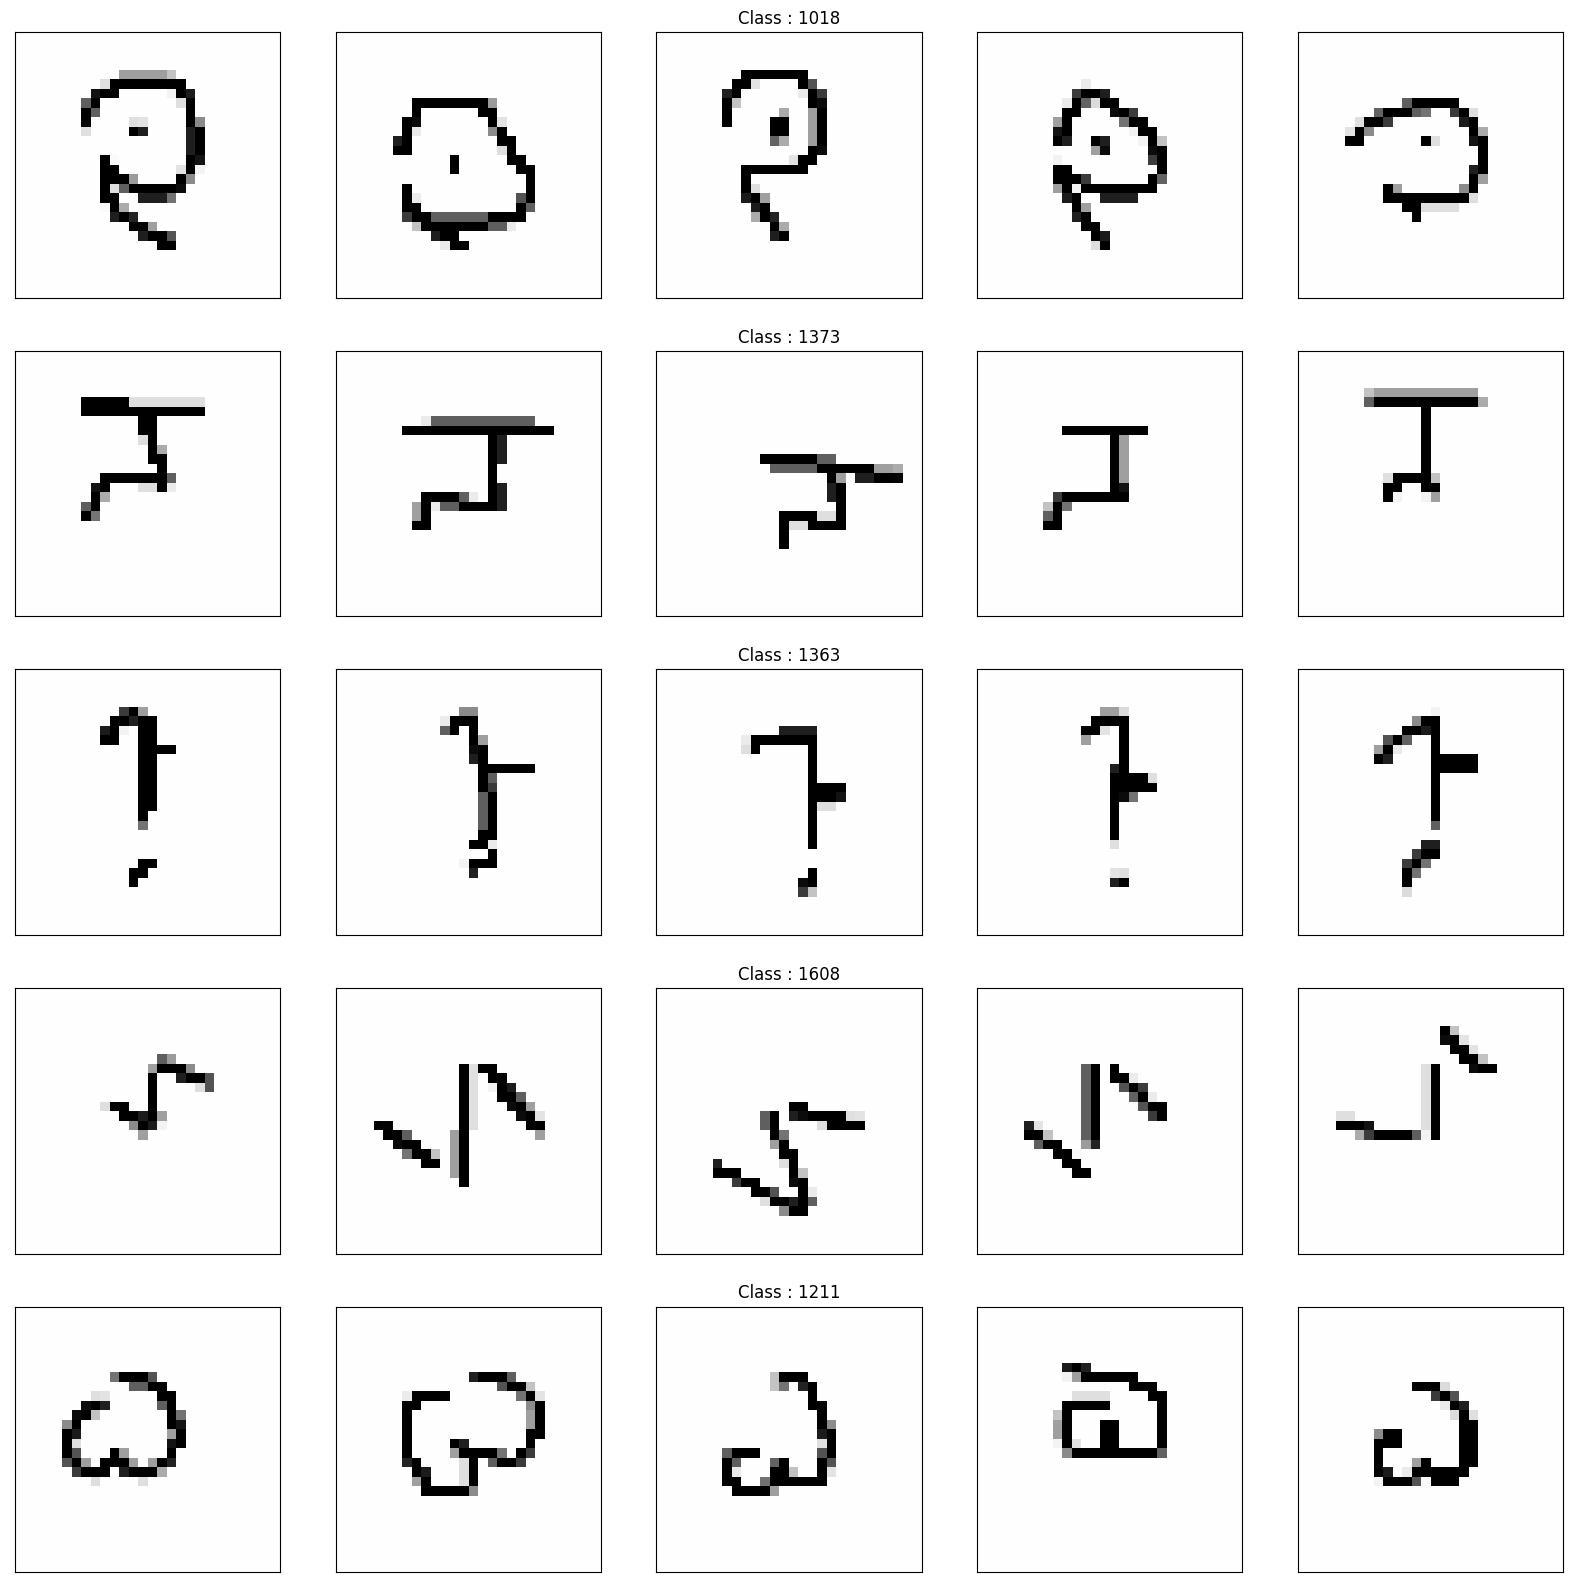

In [14]:
_, axarr = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

sample_keys = list(test_dataset.data.keys())
random_classes = random.sample(sample_keys, 5)

for a in range(5):
    for b in range(5):
        temp_image = test_dataset.data[random_classes[a]][b]
        temp_image = np.stack((temp_image[:, :, 0],) * 3, axis=2)
        temp_image *= 255
        temp_image = np.clip(temp_image, 0, 255).astype("uint8")
        if b == 2:
            axarr[a, b].set_title("Class : " + random_classes[a])
        axarr[a, b].imshow(temp_image, cmap="gray")
        axarr[a, b].xaxis.set_visible(False)
        axarr[a, b].yaxis.set_visible(False)
plt.show()

Build the model

In [6]:
def conv_bn(x):
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)


inputs = layers.Input(shape=(28, 28, 1))
x = conv_bn(inputs)
x = conv_bn(x)
x = conv_bn(x)
x = conv_bn(x)
x = layers.Flatten()(x)
outputs = layers.Dense(classes, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile()
model.summary()
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
re_lu (ReLU)                 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 7, 7, 64)          0     

In [7]:
training = []
testing = []
#每個metalearning step
for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    # 是隨著訓練進程逐漸減小的學習率
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    # 用於在元訓練步驟中恢復初始權重.   
    old_vars = model.get_weights()
    #從minidataset中sample出m-way k-shot
    mini_dataset = train_dataset.get_mini_dataset(
        inner_batch_size, inner_iters, train_shots, classes
    )
    #計算每個task的在model中的梯度
    for images, labels in mini_dataset:
        with tf.GradientTape() as tape:
            preds = model(images)
            loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        #zip function pairs each gradient with its corresponding trainable parameter
        #apply_gradientsThis method updates the model's trainable parameters using the provided gradients.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    new_vars = model.get_weights()
    #以上為從數據集中sample出minidataset(m-way k-shot)，每個minidataset(m-way k-shot)也就是一個task，對這個minidataset訓練，從訓練完後的這組weight
    # Perform SGD for the meta step. 也就是phi = phi + learningrate*(gradient)
    for var in range(len(new_vars)):
        new_vars[var] = old_vars[var] + (
            (new_vars[var] - old_vars[var]) * cur_meta_step_size
        )
    # After the meta-learning step, reload the newly-trained weights into the model.
    model.set_weights(new_vars)
    # Evaluation loop
    if meta_iter % eval_interval == 0:
        accuracies = []
        for dataset in (train_dataset, test_dataset):
            # Sample a mini dataset from the full dataset.
            train_set, test_images, test_labels = dataset.get_mini_dataset(
                eval_batch_size, eval_iters, shots, classes, split=True
            )
            old_vars = model.get_weights()
            # Train on the samples and get the resulting accuracies.
            for images, labels in train_set:
                with tf.GradientTape() as tape:
                    preds = model(images)
                    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
            test_preds = model.predict(test_images)
            test_preds = tf.argmax(test_preds).numpy()
            num_correct = (test_preds == test_labels).sum()
            # Reset the weights after getting the evaluation accuracies.
            model.set_weights(old_vars)
            accuracies.append(num_correct / classes)
        training.append(accuracies[0])
        testing.append(accuracies[1])
        if meta_iter % 100 == 0:
            print(
                "batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1])
            )

batch 0: train=0.400000 test=0.400000
batch 100: train=0.800000 test=0.700000
batch 200: train=0.900000 test=0.900000
batch 300: train=0.900000 test=0.700000
batch 400: train=0.700000 test=0.700000
batch 500: train=0.700000 test=0.600000
batch 600: train=1.000000 test=0.800000
batch 700: train=0.900000 test=1.000000
batch 800: train=1.000000 test=0.900000
batch 900: train=0.900000 test=0.800000
batch 1000: train=0.900000 test=0.900000
batch 1100: train=0.800000 test=1.000000
batch 1200: train=1.000000 test=1.000000
batch 1300: train=1.000000 test=1.000000
batch 1400: train=1.000000 test=0.900000
batch 1500: train=0.900000 test=1.000000
batch 1600: train=1.000000 test=1.000000
batch 1700: train=1.000000 test=0.700000
batch 1800: train=0.900000 test=0.800000
batch 1900: train=1.000000 test=1.000000
batch 2000: train=1.000000 test=0.900000


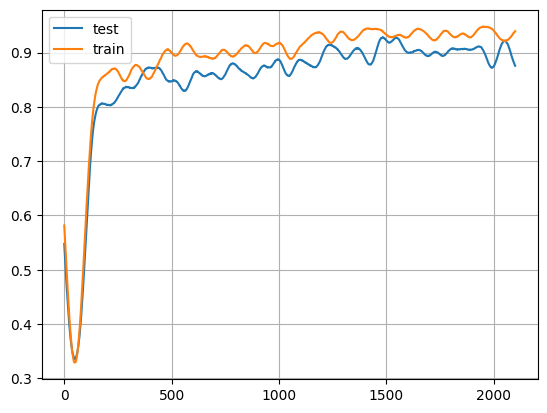

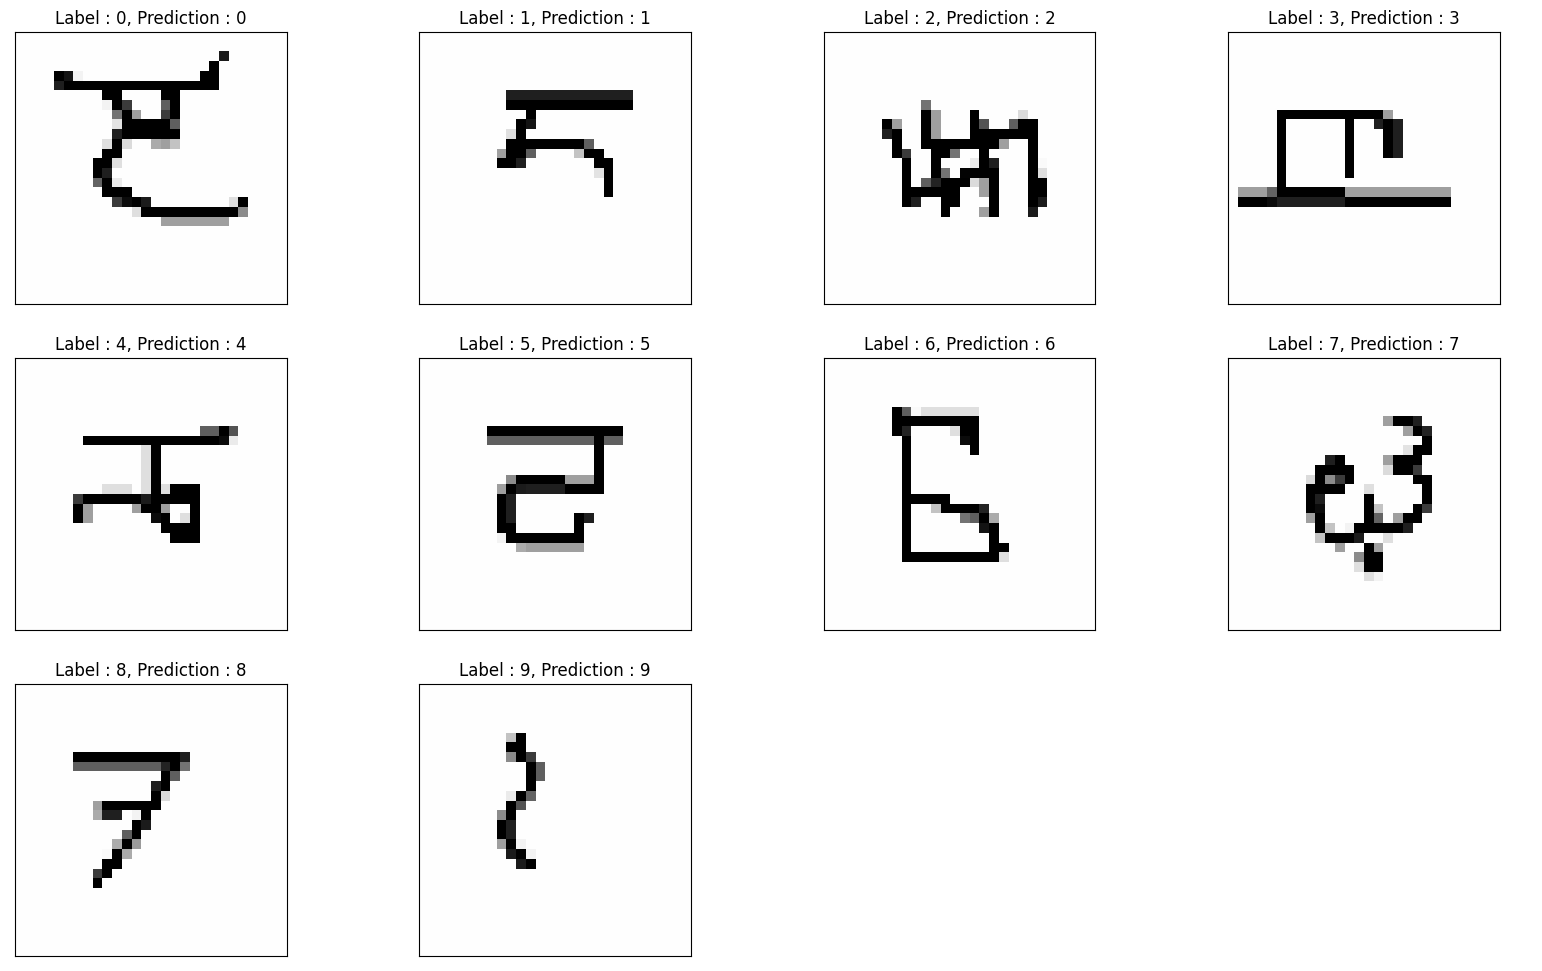

In [9]:
window_length = 100
train_s = np.r_[
    training[window_length - 1 : 0 : -1],
    training,
    training[-1:-window_length:-1],
]
test_s = np.r_[
    testing[window_length - 1 : 0 : -1], testing, testing[-1:-window_length:-1]
]
w = np.hamming(window_length)
train_y = np.convolve(w / w.sum(), train_s, mode="valid")
test_y = np.convolve(w / w.sum(), test_s, mode="valid")

# Display the training accuracies.
x = np.arange(0, len(test_y), 1)
plt.plot(x, test_y, x, train_y)
plt.legend(["test", "train"])
plt.grid()

train_set, test_images, test_labels = dataset.get_mini_dataset(
    eval_batch_size, eval_iters, shots, classes, split=True
)
for images, labels in train_set:
    with tf.GradientTape() as tape:
        preds = model(images)
        loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
test_preds = model.predict(test_images)
test_preds = tf.argmax(test_preds).numpy()

k = classes  # 設置你想要顯示的分類結果數量

# 確定子圖的行數和列數，這裡以每行顯示5個圖像為例
ncols = 4
nrows = (k + ncols - 1) // ncols  # 向上取整

_, axarr = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 4 * nrows))

# 確保axarr是2D陣列
axarr = np.array(axarr).reshape(nrows, ncols)

for i in range(k):
    row = i // ncols
    col = i % ncols
    ax = axarr[row, col]
    temp_image = np.stack((test_images[i, :, :, 0],) * 3, axis=2)
    temp_image *= 255
    temp_image = np.clip(temp_image, 0, 255).astype("uint8")
    ax.set_title(
        "Label : {}, Prediction : {}".format(int(test_labels[i]), test_preds[i])
    )
    ax.imshow(temp_image, cmap="gray")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

# 如果有多餘的子圖，需要將其隱藏
for j in range(i + 1, nrows * ncols):
    row = j // ncols
    col = j % ncols
    axarr[row, col].axis('off')

plt.show()

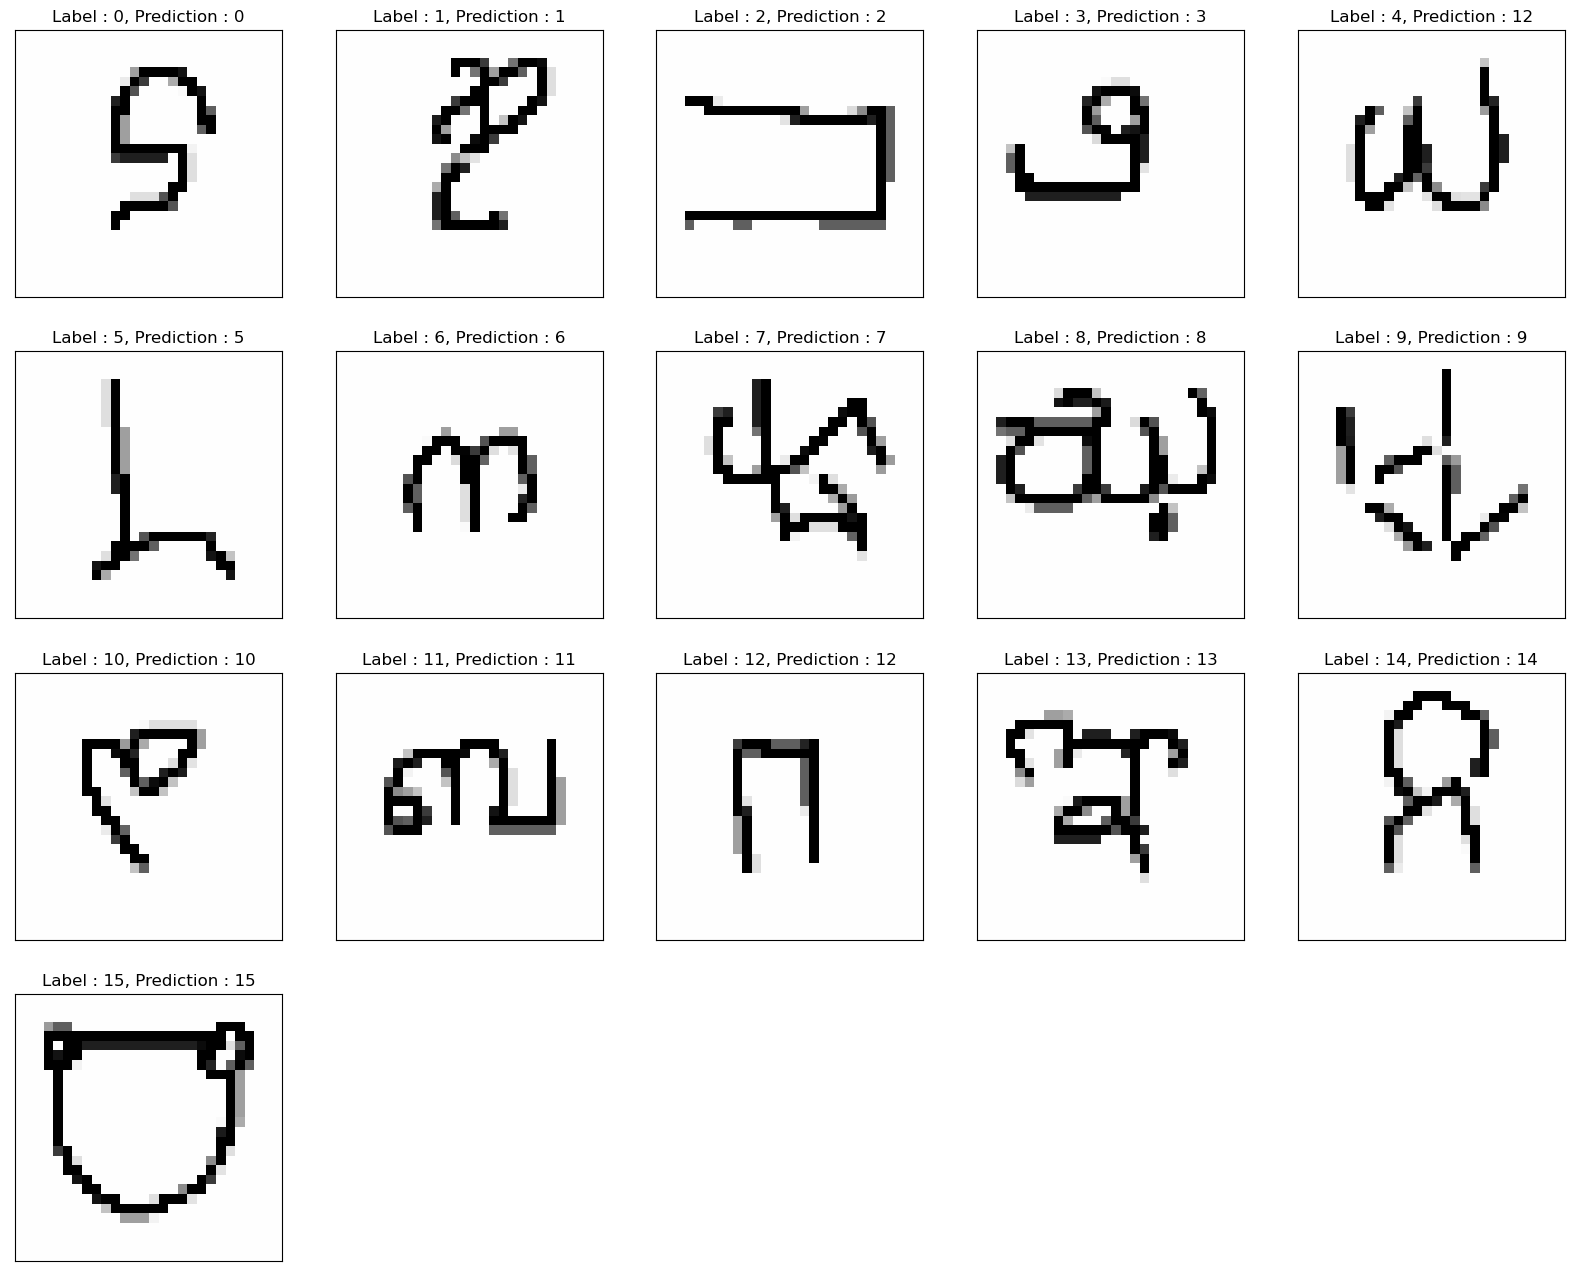

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# 假設你已經有test_images, test_labels, test_preds

k = classes  # 設置你想要顯示的分類結果數量

# 確定子圖的行數和列數，這裡以每行顯示5個圖像為例
ncols = 5
nrows = (k + ncols - 1) // ncols  # 向上取整

_, axarr = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 4 * nrows))

# 確保axarr是2D陣列
axarr = np.array(axarr).reshape(nrows, ncols)

for i in range(k):
    row = i // ncols
    col = i % ncols
    ax = axarr[row, col]
    temp_image = np.stack((test_images[i, :, :, 0],) * 3, axis=2)
    temp_image *= 255
    temp_image = np.clip(temp_image, 0, 255).astype("uint8")
    ax.set_title(
        "Label : {}, Prediction : {}".format(int(test_labels[i]), test_preds[i])
    )
    ax.imshow(temp_image, cmap="gray")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

# 如果有多餘的子圖，需要將其隱藏
for j in range(i + 1, nrows * ncols):
    row = j // ncols
    col = j % ncols
    axarr[row, col].axis('off')

plt.show()
